In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [40]:
df_ext = pd.read_csv('../data/raw/dating_app_behavior_dataset_extended1.csv')

In [43]:
df = df_ext.copy()

In [44]:
df['target_binary'] = df['match_outcome'].isin([
    'Mutual Match',
    'Date Happened',
    'Relationship Formed',
    'Instant Match'
]).astype(int)

In [45]:
features = df.drop(columns = ['target_binary','match_outcome'])
target = df['target_binary']

In [46]:
# Nominal 
nominal_cols = [
    'gender',
    'sexual_orientation',
    'location_type',
    'swipe_time_of_day',
    'zodiac_sign',
    'body_type',
    'relationship_intent'
]

In [47]:
social = {
    'Clubbing',
    'Dancing',
    'Stand-up Comedy',
    'Board Games',
    'Gaming',
    'Social Activism',
    'Pets',
    'K-pop',
    'Skating'
}

In [48]:
solo = {
    'Reading',
    'Writing',
    'Poetry',
    'Meditation',
    'Yoga',
    'Painting',
    'DIY',
    'Crafting',
    'Coding',
    'History',
    'Investing',
    'Gardening',
    'Astrology'
}

In [49]:
mixed = {
    'Fitness',
    'Traveling',
    'Movies',
    'Cooking',
    'Hiking',
    'Foodie',
    'Art',
    'Music',
    'Photography',
    'Running',
    'Motorcycling',
    'Anime',
    'Tech',
    'Startups',
    'Languages',
    'Fashion',
    'Makeup',
    'Sneaker Culture',
    'Cars',
    'MMA',
    'Podcasts',
    'Memes',
    'Binge-Watching',
    'Politics',
    'Parenting',
    'Spirituality',
    'Tattoos'
}

In [50]:
# interest
interest_groups = {
    'social': social,
    'solo': solo,
    'mixed': mixed
}

In [51]:
def interest_group_counts(x):
    if pd.isna(x) or x == '':
        interest_list = []
    else:
        interest_list = [i.strip() for i in x.split(',')]

    return {
        'n_social_interaction_based': sum(i in social for i in interest_list),
        'n_individual_solo_oriented': sum(i in solo for i in interest_list),
        'n_mixed_context_dependent': sum(i in mixed for i in interest_list),
    }

interest_group_df = (
    df['interest_tags']     
    .apply(interest_group_counts)
    .apply(pd.Series)
)

In [52]:
interest_cols = [
    'n_social_interaction_based',
    'n_individual_solo_oriented',
    'n_mixed_context_dependent'
]
interest_cols

['n_social_interaction_based',
 'n_individual_solo_oriented',
 'n_mixed_context_dependent']

In [53]:
# Numerical
numerical_cols = [
    'app_usage_time_min',
    'swipe_right_ratio',
    'likes_received',
    'mutual_matches',
    'profile_pics_count',
    'bio_length',
    'message_sent_count',
    'emoji_usage_rate',
    'last_active_hour',
    'age',
    'height_cm',
    'weight_kg'
]

In [54]:
# Ordinal
ordinal_cols = [
    'income_bracket',
    'education_level',
    'app_usage_time_label',
    'swipe_right_label'
]


In [55]:
income_order = [
    'Very Low',
    'Low',
    'Lower-Middle',
    'Middle',
    'Upper-Middle',
    'High',
    'Very High'
]

In [56]:
education_order = [
    'No Formal Education',
    'High School',
    'Diploma',
    'Associate’s',
    'Bachelor’s',
    'Master’s',
    'MBA',
    'PhD',
    'Postdoc'
]

In [57]:
app_usage_order = [
    'Very Low',
    'Barely',
    'Low',
    'Moderate',
    'High',
    'Extreme User',
    'Addicted'
]

In [58]:
swipe_order = [
    'Choosy',
    'Balanced',
    'Optimistic',
    'Swipe Maniac'
]

In [59]:
ordinal_categories = [
    income_order,
    education_order,
    app_usage_order,
    swipe_order
]

In [60]:
df_model = df.copy()
df_model = pd.concat([df.copy(), interest_group_df], axis=1)
X = df_model[numerical_cols + ordinal_cols + nominal_cols + interest_cols]
y = target

In [62]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=0,
    stratify=y
)

In [63]:
# transformer
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), nominal_cols),
        ('interest', 'passthrough', interest_cols)
    ],
    remainder='drop'
)

In [64]:
X_pre = preprocess.fit_transform(X_train)

print("X_train shape:", X_train.shape)
print("After preprocess shape:", X_pre.shape)
print("Type:", type(X_pre))

X_train shape: (40000, 26)
After preprocess shape: (40000, 62)
Type: <class 'numpy.ndarray'>


In [65]:
feature_names = preprocess.get_feature_names_out()
X_pre_df = pd.DataFrame(X_pre, columns=feature_names)
X_pre_df.head()

,num__app_usage_time_min,num__swipe_right_ratio,num__likes_received,num__mutual_matches,num__profile_pics_count,num__bio_length,num__message_sent_count,num__emoji_usage_rate,num__last_active_hour,num__age,...,cat__body_type_Plus Size,cat__body_type_Slim,cat__relationship_intent_Exploring,cat__relationship_intent_Friends Only,cat__relationship_intent_Hookups,cat__relationship_intent_Networking,cat__relationship_intent_Serious Relationship,interest__n_social_interaction_based,interest__n_individual_solo_oriented,interest__n_mixed_context_dependent
0,0.365680,0.303654,-0.544406,1.002563,0.006940,0.185962,-1.064985,-0.413464,-0.074134,-0.365858,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
1,0.687540,0.405057,0.455908,1.551615,-1.496379,-0.898582,0.751229,-0.913129,-1.086009,-0.283455,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
2,-0.622890,0.405057,-0.785861,-0.754403,1.009153,-1.078188,1.059643,-0.163631,0.214973,-0.036245,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
3,-0.427475,0.912069,-1.579213,-0.864213,-0.995272,-1.409769,0.579888,-0.850671,1.371401,1.447014,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
4,-0.772325,0.861367,-0.578899,-1.413265,0.508047,0.918203,-1.202058,-0.663296,0.793187,0.375771,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0


Logistic Regression
Logistic Regression is suitable for our dataset because the target variable is binary and the features represent user behaviors that may have a linear relationship with the probability of a mutual match. Additionally, the model provides high interpretability, allowing us to understand the impact of each feature.

Descision Tree
Decision Tree is appropriate for this dataset as it can capture non-linear relationships and interaction effects between user behaviors. It also provides intuitive decision rules that help explain how different behavior patterns lead to different match outcomes.

0.5068
              precision    recall  f1-score   support

           0       0.61      0.52      0.56      6030
           1       0.40      0.49      0.44      3970

    accuracy                           0.51     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.52      0.51      0.51     10000



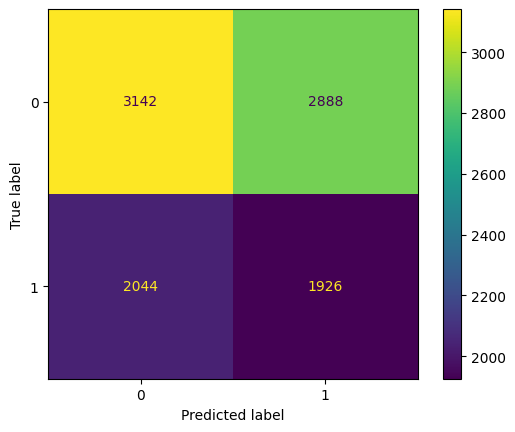

In [66]:
# train model-Logistic Regression
model_bal = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

model_bal.fit(X_train, y_train)

y_pred_bal = model_bal.predict(X_test)


print(model_bal.score(X_test, y_test))
print(classification_report(y_test, y_pred_bal))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bal)

	•	TP (True Positive) = 1926: The true label is 1 and the model also predicts 1 ✅ (correctly identified a match).
	•	FN (False Negative) = 2044: The true label is 1 but the model predicts 0 ❌ (missed matches).
	•	FP (False Positive) = 2888: The true label is 0 but the model predicts 1 ❌ (false match predictions).
	•	TN (True Negative) = 3142: The true label is 0 and the model also predicts 0 ✅ (correctly identified non-matches).


In [77]:
lr_smote_pipe = ImbPipeline(steps=[
    ('preprocess', preprocess),         
    ('smote', SMOTE(random_state=0)),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=0
    ))
])


=== SMOTE + LR + class_weight=balanced ===
              precision    recall  f1-score   support

           0      0.598     0.517     0.555      6030
           1      0.392     0.473     0.428      3970

    accuracy                          0.499     10000
   macro avg      0.495     0.495     0.492     10000
weighted avg      0.516     0.499     0.505     10000



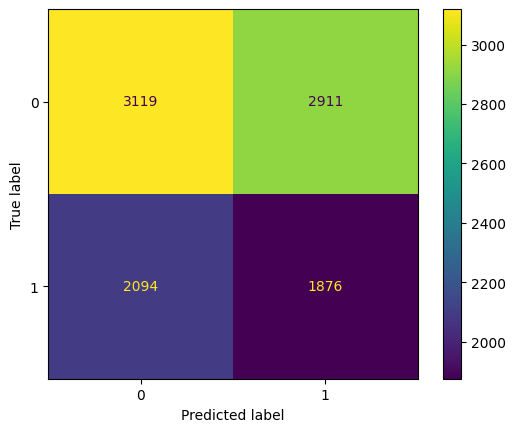

In [78]:
lr_smote_bal = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=0)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_smote_bal.fit(X_train, y_train)
y_pred_smote_bal = lr_smote_bal.predict(X_test)

print("\n=== SMOTE + LR + class_weight=balanced ===")
print(classification_report(y_test, y_pred_smote_bal, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_smote_bal)

In [ ]:
def summarize(y_true, y_pred, name):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    acc = accuracy_score(y_true, y_pred)
    return {'model': name, 'accuracy': acc, 'precision_1': p, 'recall_1': r, 'f1_1': f1}

rows = []
rows.append(summarize(y_test, y_pred_bal, "LR balanced"))
rows.append(summarize(y_test, y_pred_smote_bal, "LR + SMOTE + balanced"))

pd.DataFrame(rows)

,model,accuracy,precision_1,recall_1,f1_1
0,LR balanced,0.5068,0.400083,0.485139,0.438525
1,LR + SMOTE + balanced,0.4995,0.391895,0.472544,0.428457


              precision    recall  f1-score   support

           0       0.60      0.28      0.39      6030
           1       0.40      0.72      0.51      3970

    accuracy                           0.46     10000
   macro avg       0.50      0.50      0.45     10000
weighted avg       0.52      0.46      0.44     10000



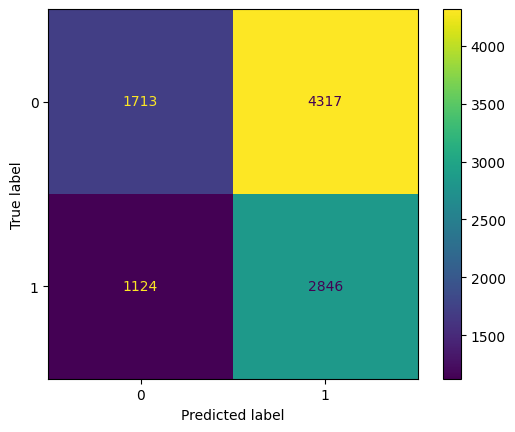

In [68]:
#Decision Tree
dt_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', DecisionTreeClassifier(
        random_state=0,
        class_weight="balanced",
        max_depth=6,
        min_samples_leaf=20,
        min_samples_split=50
    ))
])

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print(classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)

In [70]:
feature_names = preprocess.get_feature_names_out()

importances = dt_model.named_steps['clf'].feature_importances_

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi_df.head(10)

,feature,importance
7,num__emoji_usage_rate,0.098378
11,num__weight_kg,0.095385
5,num__bio_length,0.088574
2,num__likes_received,0.087892
0,num__app_usage_time_min,0.083139
1,num__swipe_right_ratio,0.078081
3,num__mutual_matches,0.064923
9,num__age,0.049122
6,num__message_sent_count,0.042421
25,cat__sexual_orientation_Pansexual,0.034275


We selected Random Forest as the candidate best-performing model because it captures non-linear relationships and feature interactions better than single models, while remaining robust to overfitting through ensemble averaging.
RandomizedSearchCV was used to efficiently explore the hyperparameter space under limited computational budget.

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best CV F1: 0.3628769046691156
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}
              precision    recall  f1-score   support

           0       0.60      0.65      0.63      6030
           1       0.40      0.35      0.37      3970

    accuracy                           0.53     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.52      0.53      0.53     10000



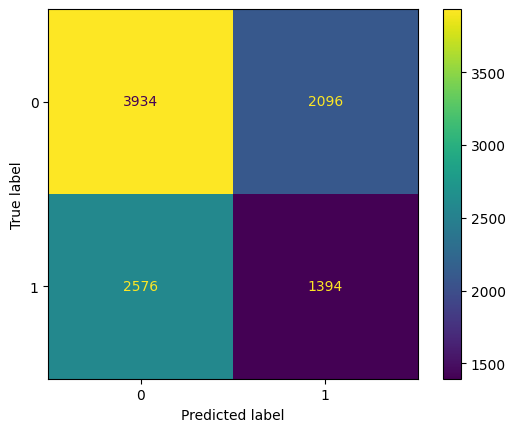

In [73]:
#Hyperparameter Tuning -> Random Forest->Random Research
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

param_distributions = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 0.8],
    'clf__class_weight': ['balanced']
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=0
)

rf_search.fit(X_train, y_train)

print("Best CV F1:", rf_search.best_score_)
print("Best params:", rf_search.best_params_)


best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [74]:
best_rf = rf_search.best_estimator_  


proba = best_rf.predict_proba(X_test)[:, 1]

print("mean proba:", proba.mean())
print("max proba:", proba.max())
print("percent >= 0.5:", (proba >= 0.5).mean())
print("percent >= 0.4:", (proba >= 0.4).mean())
print("percent >= 0.3:", (proba >= 0.3).mean())


for thr in [0.30, 0.35, 0.40, 0.45, 0.50]:
    y_pred_thr = (proba >= thr).astype(int)
    print("\nthreshold =", thr)
    print(classification_report(y_test, y_pred_thr, digits=3))

mean proba: 0.492749863666261
max proba: 0.5612273751577707
percent >= 0.5: 0.349
percent >= 0.4: 0.9999
percent >= 0.3: 1.0

threshold = 0.3
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      6030
           1      0.397     1.000     0.568      3970

    accuracy                          0.397     10000
   macro avg      0.199     0.500     0.284     10000
weighted avg      0.158     0.397     0.226     10000


threshold = 0.35
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      6030
           1      0.397     1.000     0.568      3970

    accuracy                          0.397     10000
   macro avg      0.199     0.500     0.284     10000
weighted avg      0.158     0.397     0.226     10000


threshold = 0.4
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      6030
           1      0.397     1.000     0.568      3970

    a

/Users/haiou/Ironhacker/week7/machine_learning_dating_app_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/haiou/Ironhacker/week7/machine_learning_dating_app_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/haiou/Ironhacker/week7/machine_learning_dating_app_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

Although the Decision Tree achieved the highest F1-score for the positive class, this came at the cost of significantly reduced performance on the negative class, indicating overfitting and poor generalization.
Random Forest demonstrated more balanced performance across classes and more stable cross-validation results. Therefore, Random Forest was selected as the final model.